In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -q faiss-cpu
!pip install -q tensorflow==2.18.0
!pip install -q skl2onnx onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 55.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 87.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.7 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import os

# Kiểm tra phiên bản TensorFlow
print(f"TensorFlow version: {tf.__version__}")

# Cấu hình memory growth để sử dụng GPU hiệu quả
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Tìm thấy {len(gpus)} GPU:")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")
    
    # Cấu hình memory growth
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Một số tùy chọn để tối ưu hiệu suất cho GPU T4
        os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
        os.environ['TF_GPU_THREAD_COUNT'] = '2'  # Tương ứng với số GPU
        
        # Hiển thị các GPU logic
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"Số lượng GPU vật lý: {len(gpus)}, số lượng GPU logic: {len(logical_gpus)}")
        
        # Thông tin chi tiết về GPU
        from tensorflow.python.client import device_lib
        local_device_protos = device_lib.list_local_devices()
        gpu_list = [x.name for x in local_device_protos if x.device_type == 'GPU']
        print(f"Danh sách GPU: {gpu_list}")
        
        # Hiển thị thông tin CUDA và cuDNN
        build_info = tf.sysconfig.get_build_info()
        print(f"CUDA version: {build_info.get('cuda_version', 'N/A')}")
        print(f"cuDNN version: {build_info.get('cudnn_version', 'N/A')}")
        
        # Kiểm tra xem GPU có thực sự được sử dụng hay không
        print("\nXác nhận GPU đang hoạt động bằng phép tính nhỏ:")
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
            c = tf.matmul(a, b)
            print(f"Tính toán trên GPU: {c}")
            print(f"Đang chạy trên thiết bị: {c.device}")
    
    except RuntimeError as e:
        print(f"Lỗi khi cấu hình GPU: {e}")
else:
    print("Không tìm thấy GPU! Đang sử dụng CPU.")
    
    # Kiểm tra thông tin CPU
    cpu_devices = tf.config.list_physical_devices('CPU')
    print(f"Tìm thấy {len(cpu_devices)} CPU: {cpu_devices}")

2025-07-04 05:31:27.810890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751607088.043822      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751607088.112621      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Tìm thấy 1 GPU:
  GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Số lượng GPU vật lý: 1, số lượng GPU logic: 1
Danh sách GPU: ['/device:GPU:0']
CUDA version: 12.5.1
cuDNN version: 9

Xác nhận GPU đang hoạt động bằng phép tính nhỏ:
Tính toán trên GPU: [[19. 22.]
 [43. 50.]]
Đang chạy trên thiết bị: /job:localhost/replica:0/task:0/device:GPU:0


I0000 00:00:1751607101.856362      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1751607101.858399      35 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [3]:
import glob
import matplotlib.pyplot as plt
import cv2
import random
import pandas as pd
import os
from PIL import Image
import warnings
import gc
import numpy as np
import csv
import time
import seaborn as sns
from tqdm import tqdm 
import shutil

import tensorflow.keras.layers as L
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Dropout, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Resizing
from tensorflow.keras.layers import MaxPooling2D, Activation, BatchNormalization, Attention, Reshape, RepeatVector, Lambda, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib

import onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Bỏ qua các cảnh báo
warnings.filterwarnings("ignore")

# In phiên bản TensorFlow hiện tại
print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed=0):
    # Thiết lập seed để đảm bảo tính tái lập (reproducibility)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Gọi hàm seed_everything để thiết lập seed mặc định
seed_everything()

TensorFlow Version 2.18.0


# Trực quan dữ liệu

In [4]:
def count_images_per_folder(root_dir, image_extensions=None):
    if image_extensions is None:
        image_extensions = ['.jpg']

    total = 0
    for subdir, dirs, files in os.walk(root_dir):
        count = sum(1 for file in files if any(file.lower().endswith(ext) for ext in image_extensions))
        if count > 0:
            relative_path = os.path.relpath(subdir, root_dir)
            # print(f"Thư mục '{relative_path}': {count} ảnh")
            total += count

    print(f"==> Tổng số ảnh: {total}")

print("====Thư mục Train====")
folder_train_path = '/kaggle/input/spectrogram-movies-dataset/Spectrogram_Dataset/Train'
count_images_per_folder(folder_train_path)

print("====Thư mục Test====")
folder_test_path = '/kaggle/input/spectrogram-movies-dataset/Spectrogram_Dataset/Test'
count_images_per_folder(folder_test_path)

====Thư mục Train====
==> Tổng số ảnh: 29693
====Thư mục Test====
==> Tổng số ảnh: 11565


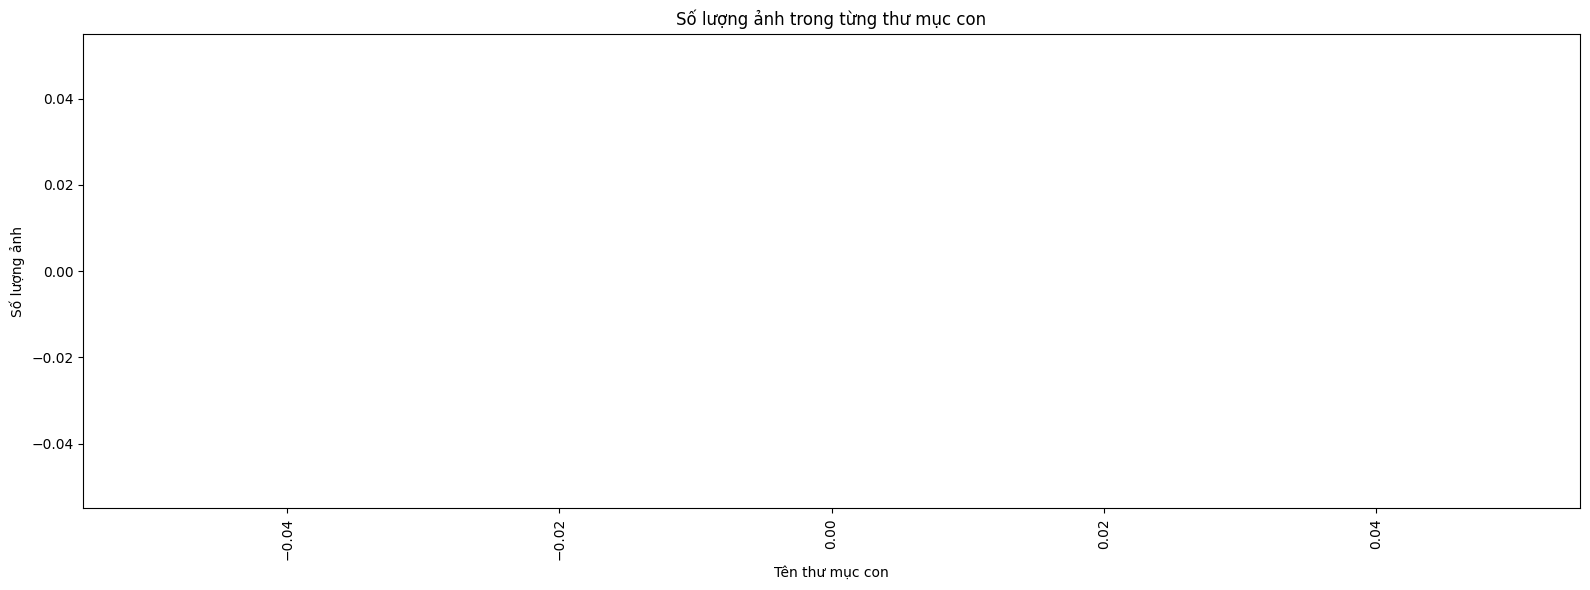

In [6]:
def count_images_per_folder(root_dir, image_extensions=None):
    if image_extensions is None:
        image_extensions = ['.jpg']

    folder_counts = {}
    for subdir, dirs, files in os.walk(root_dir):
        if subdir == root_dir:
            continue  # bỏ qua thư mục gốc
        count = sum(1 for file in files if any(file.lower().endswith(ext) for ext in image_extensions))
        if count > 0:
            folder_name = os.path.basename(subdir)
            folder_counts[folder_name] = count

    return folder_counts

def plot_image_counts(folder_counts):
    folders = list(folder_counts.keys())
    counts = list(folder_counts.values())

    plt.figure(figsize=(16, 6))
    plt.bar(folders, counts, color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel('Tên thư mục con')
    plt.ylabel('Số lượng ảnh')
    plt.title('Số lượng ảnh trong từng thư mục con')
    plt.tight_layout()
    plt.show()

# Tập Train
counts = count_images_per_folder(folder_train_path)
plot_image_counts(counts)

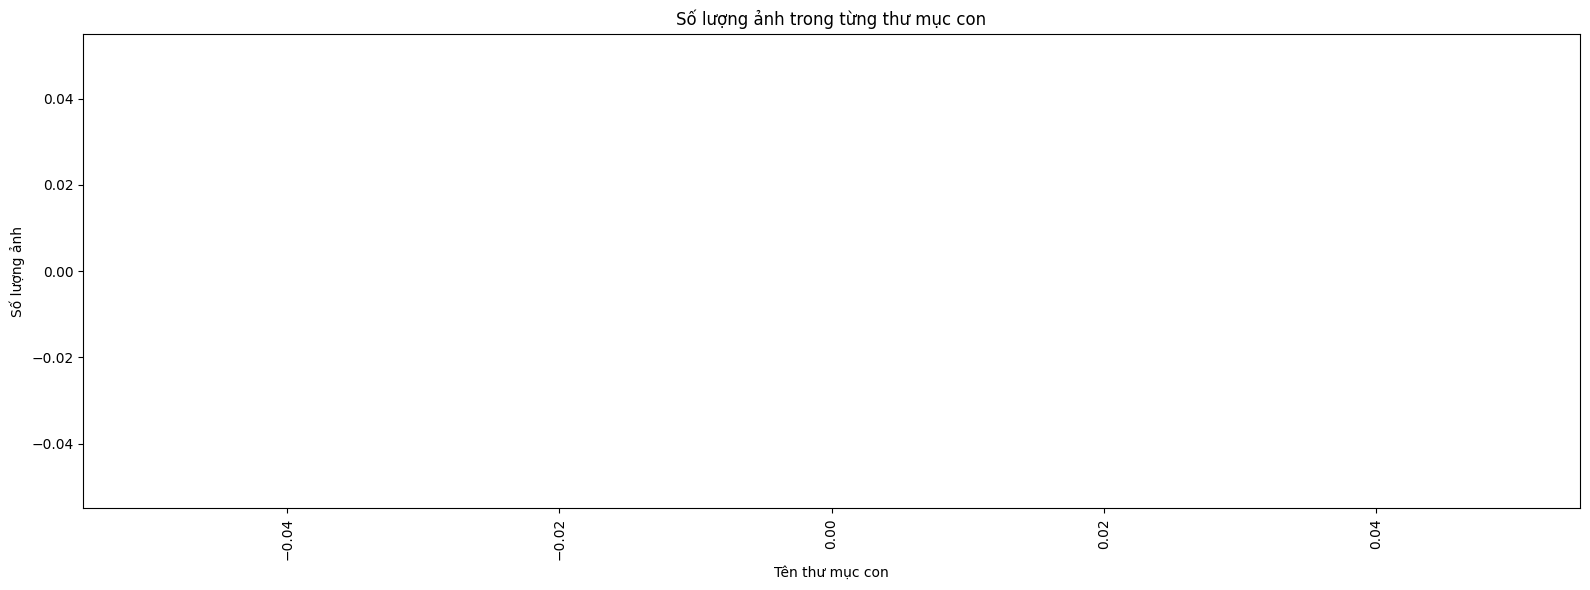

In [7]:
# Tập Test
counts = count_images_per_folder(folder_test_path)
plot_image_counts(counts)

# Tạo tập dữ liệu

In [5]:
image_size = 224
n_classes = 45
batch_size = 32

classes_train = {
    1: "21_Ngay_Yeu_Em",
    2: "4_Nam_2_Chang_1_Tinh_Yeu",
    3: "An_Tet_Ben_Con",
    4: "Bay_Ngot_Ngao",
    5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat",
    7: "Bi_Mat_Trong_Suong_Mu",
    8: "Bo_Tu_Oan_Gia",
    9: "Cho_Em_Den_Ngay_Mai",
    10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet",
    12: "Co_Ba_Sai_Gon",
    13: "Dao_Pho_Va_Piano",
    14: "Dat_Rung_Phuong_Nam",
    15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y",
    17: "Doi_Mat_Am_Duong",
    18: "Em_Chua_18",
    19: "Em_La_Cua_Em",
    20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat",
    22: "Hem_Cut",
    23: "Hoan_Doi",
    24: "Ke_An_Danh",
    25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma",
    27: "Lat_Mat_1",
    28: "Lo_Mat",
    29: "Ma_Da",
    30: "Mat_Biec",
    31: "Nghe_Sieu_De",
    32: "Nhung_Nu_Hon_Ruc_Ro",
    33: "Ong_Ngoai_Tuoi_30",
    34: "Phap_Su_Tap_Su",
    35: "Quy_Cau",
    36: "Quy_Co_Thua_Ke",
    37: "Ra_Mat_Gia_Tien",
    38: "Sieu_Lua_Gap_Sieu_Lay",
    39: "Sieu_Tro_Ly",
    40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi",
    42: "The_Call",
    43: "Thien_Menh_Anh_Hung",
    44: "Tieu_Thu_Va_Ba_Dau_Gau",
    45: "Tren_Ban_Nhau_Duoi_Ban_Muu"
}

In [6]:
classes_test = {
    1: "21_Ngay_Yeu_Em",
    2: "4_Nam_2_Chang_1_Tinh_Yeu",
    3: "An_Tet_Ben_Con",
    4: "Bay_Ngot_Ngao",
    5: "Benh_Vien_Ma",
    6: "Bi_Mat_Lai_Bi_Mat",
    7: "Bi_Mat_Trong_Suong_Mu",
    8: "Bo_Tu_Oan_Gia",
    9: "Cho_Em_Den_Ngay_Mai",
    10: "Chu_Tich_Giao_Hang",
    11: "Chuyen_Tet",
    12: "Co_Ba_Sai_Gon",
    13: "Dao_Pho_Va_Piano",
    14: "Dat_Rung_Phuong_Nam",
    15: "Dia_Dao",
    16: "Dinh_Menh_Thien_Y",
    17: "Doi_Mat_Am_Duong",
    18: "Em_Chua_18",
    19: "Em_La_Cua_Em",
    20: "Gai_Gia_Lam_Chieu_3",
    21: "Gia_Ngheo_Gap_Phat",
    22: "Hem_Cut",
    23: "Hoan_Doi",
    24: "Ke_An_Danh",
    25: "Ke_An_Hon",
    26: "Lam_Giau_Voi_Ma",
    27: "Lat_Mat_1",
    28: "Lo_Mat",
    29: "Ma_Da",
    30: "Mat_Biec",
    31: "Nghe_Sieu_De",
    32: "Nhung_Nu_Hon_Ruc_Ro",
    33: "Ong_Ngoai_Tuoi_30",
    34: "Phap_Su_Tap_Su",
    35: "Quy_Cau",
    36: "Quy_Co_Thua_Ke",
    37: "Ra_Mat_Gia_Tien",
    38: "Sieu_Lua_Gap_Sieu_Lay",
    39: "Sieu_Tro_Ly",
    40: "Tam_Cam_Chuyen_Chua_Ke",
    41: "Taxi_Em_Ten_Gi",
    42: "The_Call",
    43: "Thien_Menh_Anh_Hung",
    44: "Tieu_Thu_Va_Ba_Dau_Gau",
    45: "Tren_Ban_Nhau_Duoi_Ban_Muu",
    46: "Khac"
}

In [7]:
train_path = '/kaggle/input/spectrogram-movies-dataset/Spectrogram_Dataset/Train'

train_df = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',  
    seed=1,
    image_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False, 
)

Found 29693 files belonging to 45 classes.


In [ ]:
images, labels = next(iter(train_df))  

fig, axes = plt.subplots(3, 3, figsize=(5, 5))
axes = axes.flatten()

for img, ax in zip(images[:9], axes): 
    ax.imshow(img.numpy().astype("uint8"))  
    ax.axis('off')

plt.tight_layout()
plt.show()

# Xóa file trong thư mục

In [20]:
def delete_all_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # xóa file hoặc symbolic link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # xóa thư mục và toàn bộ nội dung bên trong
        except Exception as e:
            print(f"Không thể xóa {file_path}: {e}")

# Ví dụ:
folder = "/kaggle/working/"
delete_all_in_folder(folder)

In [ ]:
gc.collect()
tf.keras.backend.clear_session()

# Resnet50

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Số batch
num_batches = tf.data.experimental.cardinality(train_df).numpy()

strategy = tf.distribute.MirroredStrategy()

# Khởi tạo model trong context của strategy
with strategy.scope():
    base_model_resnet50 = ResNet50(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(image_size, image_size, 3)
    )

# Nơi lưu đặc trưng và nhãn
all_features = []
all_labels = []

# Lặp qua từng batch
for images, labels in tqdm(train_df, total=num_batches, desc="Extracting features"):
    images_pp = preprocess_input(images)
    features_batch = base_model_resnet50(images_pp, training=False)
    all_features.append(features_batch.numpy())
    all_labels.append(labels.numpy())

# Đánh nhãn ứng với đặc trưng
features_array = np.concatenate(all_features, axis=0)
labels_array = np.concatenate(all_labels, axis=0)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Extracting features: 100%|██████████| 928/928 [03:22<00:00,  4.59it/s]


In [10]:
import faiss
import numpy as np

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # thêm epsilon để tránh chia cho 0

# Chuẩn hóa vector đặc trưng
normalized_features = l2_normalize(features_array.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)
print("Đã thêm", index.ntotal, "vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", labels_array)

Đã thêm 29693 vector đã chuẩn hóa vào FAISS index.


✅ FAISS index đã được tải thành công!
   - Số lượng vectors: 29693
   - Kích thước vector: 2048


Testing with FAISS: 100%|██████████| 11565/11565 [20:51<00:00,  9.24it/s] 



✅ Accuracy: 77.16%
✅ Đúng: 8924 / ❌ Sai: 2641

⏱️ Thời gian xử lý trung bình: 0.1075 giây/ảnh
⏱️ Tổng thời gian xử lý: 1243.26 giây cho 11565 ảnh


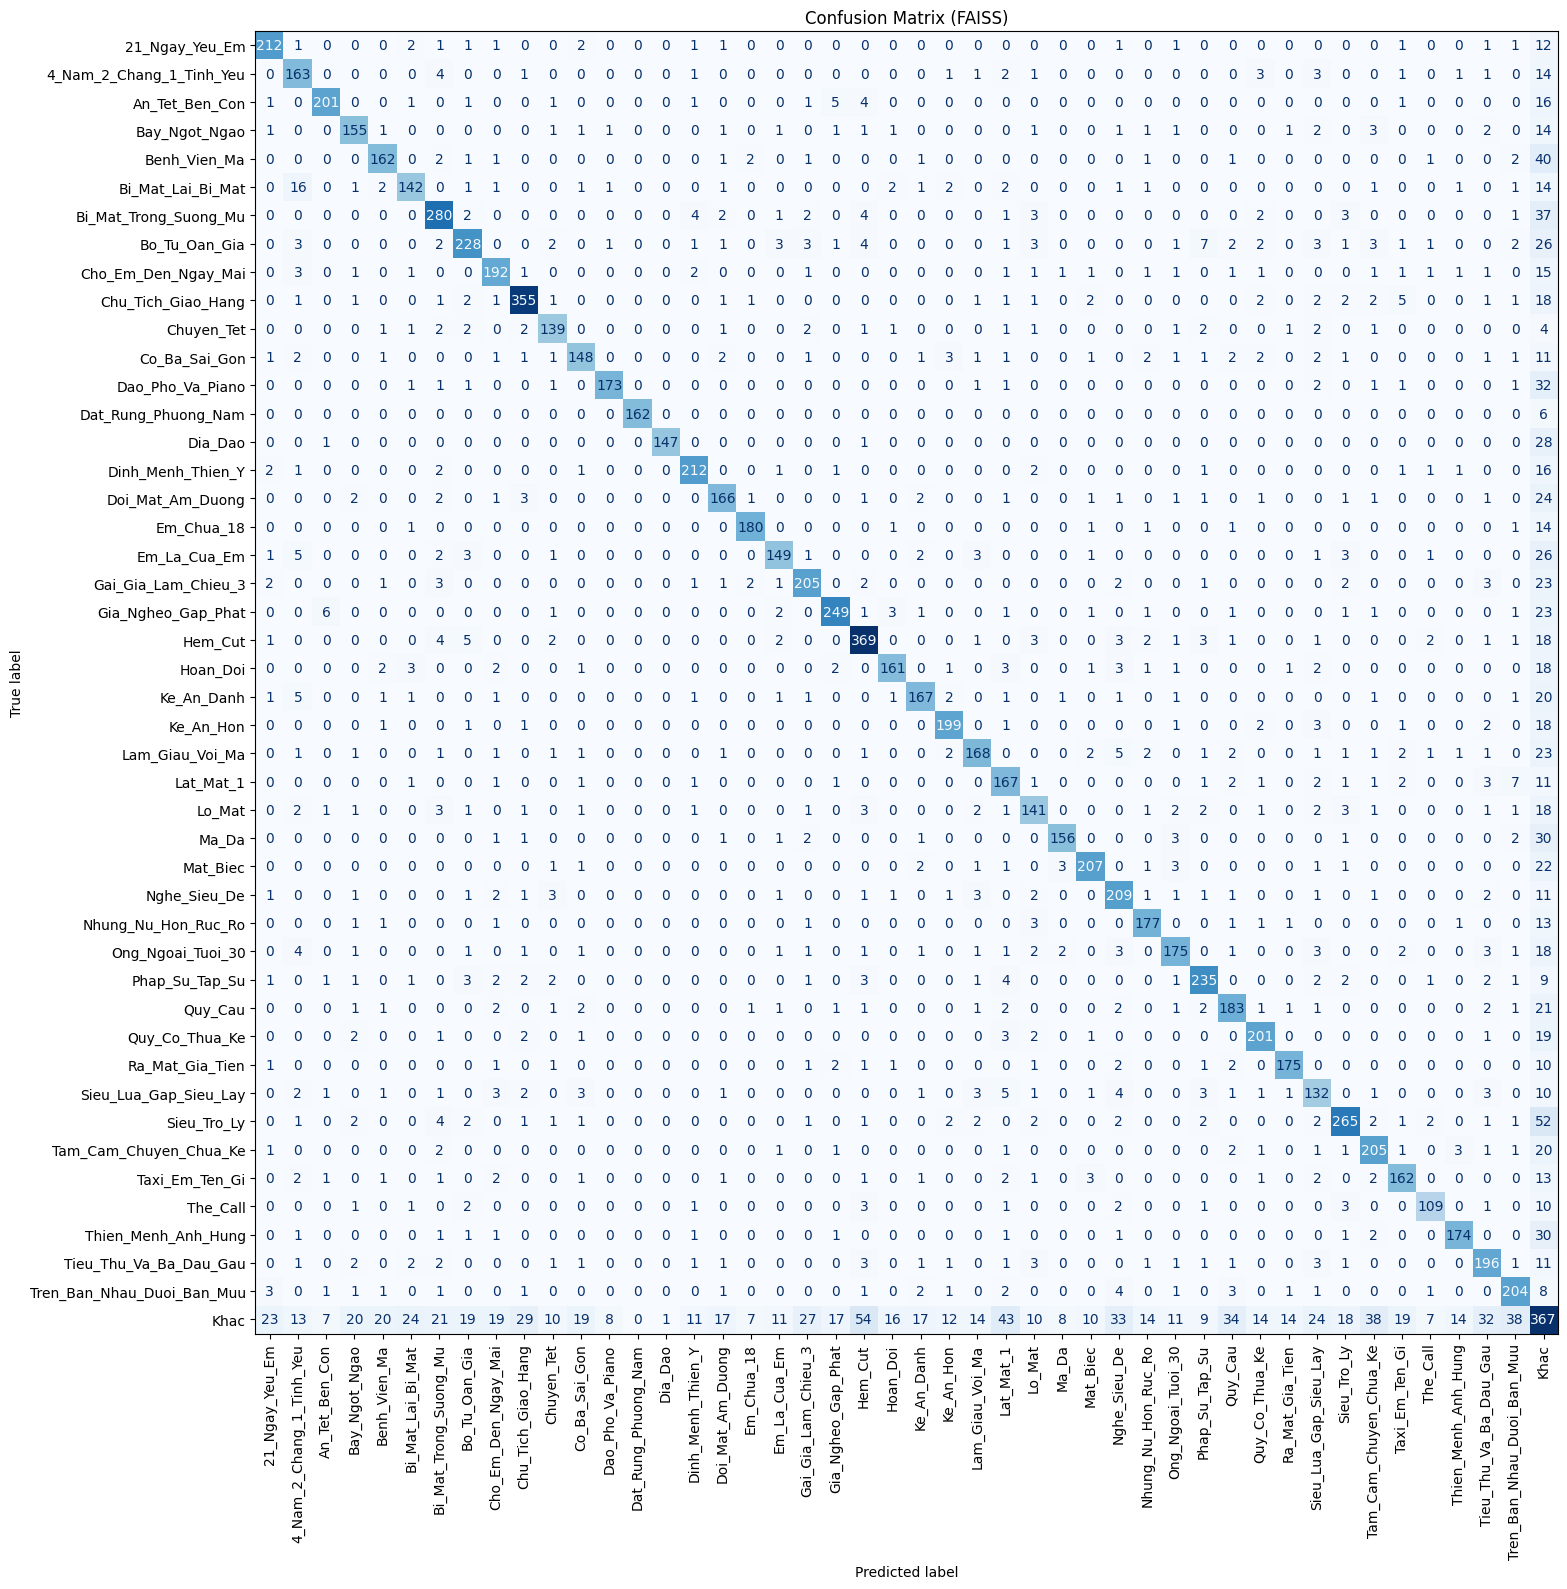


🖼️ Confusion matrix đã được lưu vào 'confusion_matrix_faiss.jpg'

📄 Classification Report:
                            precision    recall  f1-score  accuracy
21_Ngay_Yeu_Em               0.841270  0.887029  0.863544  0.771639
4_Nam_2_Chang_1_Tinh_Yeu     0.718062  0.827411  0.768868  0.771639
An_Tet_Ben_Con               0.913636  0.862661  0.887417  0.771639
Bay_Ngot_Ngao                0.794872  0.811518  0.803109  0.771639
Benh_Vien_Ma                 0.822335  0.750000  0.784504  0.771639
Bi_Mat_Lai_Bi_Mat            0.780220  0.739583  0.759358  0.771639
Bi_Mat_Trong_Suong_Mu        0.813953  0.818713  0.816327  0.771639
Bo_Tu_Oan_Gia                0.820144  0.754967  0.786207  0.771639
Cho_Em_Den_Ngay_Mai          0.810127  0.838428  0.824034  0.771639
Chu_Tich_Giao_Hang           0.876543  0.883085  0.879802  0.771639
Chuyen_Tet                   0.812865  0.842424  0.827381  0.771639
Co_Ba_Sai_Gon                0.791444  0.783069  0.787234  0.771639
Dao_Pho_Va_Piano        

In [13]:
# Cài đặt các tham số
image_size = 224
test_path = "/kaggle/input/spectrogram-movies-dataset/Spectrogram_Dataset/Test"
index_path = "faiss_features.index" 
label_path = "faiss_labels.npy"      
confusion_output_path = "confusion_matrix_faiss.jpg"
csv_output_path = "classification_report_faiss.csv"
similarity_threshold = 0.95

# ==== Load mô hình và FAISS index ====
# Load mô hình ResNet50 
model = ResNet50(include_top=False, weights='imagenet', pooling='avg', input_shape=(image_size, image_size, 3))

# Kiểm tra đường dẫn FAISS index và labels
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")

# Load FAISS index và labels
try:
    # Load index trực tiếp cho CPU
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")
except Exception as e:
    print(f"❌ Lỗi khi tải FAISS index: {e}")

# ==== Mapping classes ====
classes = classes_test
class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    # Lấy danh sách tất cả ảnh trong thư mục này
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

# ==== Dự đoán ====
processing_times = []  # Danh sách lưu thời gian xử lý từng ảnh
for img_path in tqdm(all_images, desc="Testing with FAISS"):
    try:
        start_time = time.time()  # Bắt đầu đo thời gian
        
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue
        img = image.load_img(img_path, target_size=(image_size, image_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Trích đặc trưng với mô hình
        feature = model.predict(x, verbose=0)
        
        # Chuẩn hóa L2 đặc trưng mẫu truy vấn để phù hợp với vector đã chuẩn hóa trong index
        feature = feature / (np.linalg.norm(feature) + 1e-10)  # Thêm epsilon để tránh chia cho 0
        
        # Đảm bảo đặc trưng có định dạng phù hợp sau khi chuẩn hóa
        feature = feature.astype(np.float32)
        
        # Tìm kiếm k=1 điểm gần nhất trong FAISS index
        D, I = index.search(feature, 1)
        
        # Kiểm tra similarity score từ khoảng cách L2 với vector đã chuẩn hóa
        # Với vector đã chuẩn hóa L2, khoảng cách Euclidean bình phương (D) và cosine similarity có quan hệ:
        # cosine_similarity = 1 - D/2
        # Khoảng cách FAISS là bình phương khoảng cách Euclidean
        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared/2  # Chuyển đổi khoảng cách thành cosine similarity
        
        # Nếu similarity dưới ngưỡng, gán nhãn "Khác" (43)
        if similarity_score < similarity_threshold:
            pred_label = 46  # Nhãn "Khác"
        else:
            # Lấy nhãn dự đoán từ FAISS
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data)

        # Lưu kết quả dự đoán và nhãn thực tế
        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)
        
        # Kết thúc đo thời gian và lưu lại
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        
        # In thông tin cho debug (có thể bỏ comment nếu cần kiểm tra)
        # print(f"Ảnh: {img_path}, Similarity: {similarity_score:.4f}, Nhãn dự đoán: {pred_label} ({idx_to_class[pred_label]})")
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")
        print(f"  Hình dạng đặc trưng: {feature.shape}, Kiểu dữ liệu: {feature.dtype}")

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=2, output_dict=True
    )
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    if "accuracy" not in report_df.columns:
        report_df["accuracy"] = accuracy
    print(report_df[["precision", "recall", "f1-score", "accuracy"]])
    
    # Hiển thị các tham số chung cho toàn bộ chương trình
    avg_precision = np.mean(report_df['precision'])
    avg_recall = np.mean(report_df['recall'])
    avg_f1 = np.mean(report_df['f1-score'])
    avg_processing_time = np.mean(processing_times)
    
    print("\n📝 Các tham số đánh giá chung:")
    print(f"  - Precision: {avg_precision:.2f}")
    print(f"  - Recall: {avg_recall:.2f}")
    print(f"  - F1-score: {avg_f1:.2f}")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1-score': avg_f1,
        'accuracy': accuracy,
        'avg_processing_time': avg_processing_time
    }
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_faiss.csv', index=False)
    print(f"\n📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_faiss.csv'")
    
    # Lưu cả báo cáo phân loại và các tham số chung vào một tệp CSV
    final_df = report_df.copy()
    final_df['average_precision'] = avg_precision
    final_df['average_recall'] = avg_recall
    final_df['average_f1-score'] = avg_f1
    final_df['average_accuracy'] = accuracy
    final_df['avg_processing_time'] = avg_processing_time
    final_df.to_csv('final_classification_report_faiss.csv', index=True)
    print(f"\n📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_faiss.csv'")

# MobileNet

In [21]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Số batch
num_batches = tf.data.experimental.cardinality(train_df).numpy()

strategy = tf.distribute.MirroredStrategy()

# Khởi tạo model trong context của strategy
with strategy.scope():
    base_model_mobilenet = MobileNet(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(image_size, image_size, 3)
    )

# Nơi lưu đặc trưng và nhãn
all_features = []
all_labels = []

# Lặp qua từng batch
for images, labels in tqdm(train_df, total=num_batches, desc="Extracting features"):
    images_pp = preprocess_input(images)
    features_batch = base_model_mobilenet(images_pp, training=False)
    all_features.append(features_batch.numpy())
    all_labels.append(labels.numpy())

# Đánh nhãn ứng với đặc trưng
features_array = np.concatenate(all_features, axis=0)
labels_array = np.concatenate(all_labels, axis=0)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Extracting features: 100%|██████████| 928/928 [01:11<00:00, 13.01it/s]


In [22]:
import faiss
import numpy as np

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # thêm epsilon để tránh chia cho 0

# Chuẩn hóa vector đặc trưng
normalized_features = l2_normalize(features_array.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)
print("Đã thêm", index.ntotal, "vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", labels_array)

Đã thêm 29693 vector đã chuẩn hóa vào FAISS index.


In [ ]:
# Cài đặt các tham số
image_size = 224
test_path = "/kaggle/input/spectrogram-movies-dataset/Spectrogram_Dataset/Test"
index_path = "faiss_features.index" 
label_path = "faiss_labels.npy"      
confusion_output_path = "confusion_matrix_faiss.jpg"
csv_output_path = "classification_report_faiss.csv"
similarity_threshold = 0.95

# ==== Load mô hình và FAISS index ====
model = MobileNet(include_top=False, weights='imagenet', pooling='avg', input_shape=(image_size, image_size, 3))

# Kiểm tra đường dẫn FAISS index và labels
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")

# Load FAISS index và labels
try:
    # Load index trực tiếp cho CPU
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")
except Exception as e:
    print(f"❌ Lỗi khi tải FAISS index: {e}")

# ==== Mapping classes ====
classes = classes_test
class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    # Lấy danh sách tất cả ảnh trong thư mục này
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

# ==== Dự đoán ====
processing_times = []  # Danh sách lưu thời gian xử lý từng ảnh
for img_path in tqdm(all_images, desc="Testing with FAISS"):
    try:
        start_time = time.time()  # Bắt đầu đo thời gian
        
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue
        img = image.load_img(img_path, target_size=(image_size, image_size))
        x = image.img_to_array(img).astype(np.float32) / 255.0
        x = np.expand_dims(x, axis=0)
        # x = preprocess_input(x)
        # Trích đặc trưng với mô hình
        feature = model.predict(x, verbose=0)
        
        # Chuẩn hóa L2 đặc trưng mẫu truy vấn để phù hợp với vector đã chuẩn hóa trong index
        feature = feature / (np.linalg.norm(feature) + 1e-10)  # Thêm epsilon để tránh chia cho 0
        
        # Đảm bảo đặc trưng có định dạng phù hợp sau khi chuẩn hóa
        feature = feature.astype(np.float32)
        
        # Tìm kiếm k=1 điểm gần nhất trong FAISS index
        D, I = index.search(feature, 1)
        
        # Kiểm tra similarity score từ khoảng cách L2 với vector đã chuẩn hóa
        # Với vector đã chuẩn hóa L2, khoảng cách Euclidean bình phương (D) và cosine similarity có quan hệ:
        # cosine_similarity = 1 - D/2
        # Khoảng cách FAISS là bình phương khoảng cách Euclidean
        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared/2  # Chuyển đổi khoảng cách thành cosine similarity
        
        # Nếu similarity dưới ngưỡng, gán nhãn "Khác" (43)
        if similarity_score < similarity_threshold:
            pred_label = 46  # Nhãn "Khác"
        else:
            # Lấy nhãn dự đoán từ FAISS
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data)

        # Lưu kết quả dự đoán và nhãn thực tế
        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)
        
        # Kết thúc đo thời gian và lưu lại
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        
        # In thông tin cho debug (có thể bỏ comment nếu cần kiểm tra)
        # print(f"Ảnh: {img_path}, Similarity: {similarity_score:.4f}, Nhãn dự đoán: {pred_label} ({idx_to_class[pred_label]})")
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")
        print(f"  Hình dạng đặc trưng: {feature.shape}, Kiểu dữ liệu: {feature.dtype}")

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=2, output_dict=True
    )
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    if "accuracy" not in report_df.columns:
        report_df["accuracy"] = accuracy
    print(report_df[["precision", "recall", "f1-score", "accuracy"]])
    
    # Hiển thị các tham số chung cho toàn bộ chương trình
    avg_precision = np.mean(report_df['precision'])
    avg_recall = np.mean(report_df['recall'])
    avg_f1 = np.mean(report_df['f1-score'])
    avg_processing_time = np.mean(processing_times)
    
    print("\n📝 Các tham số đánh giá chung:")
    print(f"  - Precision: {avg_precision:.2f}")
    print(f"  - Recall: {avg_recall:.2f}")
    print(f"  - F1-score: {avg_f1:.2f}")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1-score': avg_f1,
        'accuracy': accuracy,
        'avg_processing_time': avg_processing_time
    }
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_faiss.csv', index=False)
    print(f"\n📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_faiss.csv'")
    
    # Lưu cả báo cáo phân loại và các tham số chung vào một tệp CSV
    final_df = report_df.copy()
    final_df['average_precision'] = avg_precision
    final_df['average_recall'] = avg_recall
    final_df['average_f1-score'] = avg_f1
    final_df['average_accuracy'] = accuracy
    final_df['avg_processing_time'] = avg_processing_time
    final_df.to_csv('final_classification_report_faiss.csv', index=True)
    print(f"\n📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_faiss.csv'")

✅ FAISS index đã được tải thành công!
   - Số lượng vectors: 29693
   - Kích thước vector: 1024


Testing with FAISS:   6%|▌         | 661/11565 [01:00<15:45, 11.53it/s]

# VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Số batch
num_batches = tf.data.experimental.cardinality(train_df).numpy()

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    base_model_vgg16 = VGG16(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(image_size, image_size, 3)
    )

# Nơi lưu đặc trưng và nhãn
all_features = []
all_labels = []

for images, labels in tqdm(train_df, total=num_batches, desc="Extracting features"):
    images_pp = preprocess_input(images)
    features_batch = base_model_vgg16(images_pp, training=False)
    all_features.append(features_batch.numpy())
    all_labels.append(labels.numpy())

# Nối đặc trưng và nhãn
features_array = np.concatenate(all_features, axis=0)
labels_array = np.concatenate(all_labels, axis=0)

In [ ]:
import faiss
import numpy as np

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # thêm epsilon để tránh chia cho 0

# Chuẩn hóa vector đặc trưng
normalized_features = l2_normalize(features_array.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)
print("Đã thêm", index.ntotal, "vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", labels_array)

In [ ]:
# Cài đặt các tham số
image_size = 224
test_path = "/kaggle/input/spectrogram-movies-dataset/Spectrogram_Dataset/Test"
index_path = "faiss_features.index" 
label_path = "faiss_labels.npy"      
confusion_output_path = "confusion_matrix_faiss.jpg"
csv_output_path = "classification_report_faiss.csv"
similarity_threshold = 0.8  

# ==== Load mô hình và FAISS index ====
# Load mô hình InceptionV3
model = VGG16(include_top=False, weights='imagenet', pooling='avg', input_shape=(image_size, image_size, 3))

# Kiểm tra đường dẫn FAISS index và labels
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")

# Load FAISS index và labels
try:
    # Load index trực tiếp cho CPU
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")
except Exception as e:
    print(f"❌ Lỗi khi tải FAISS index: {e}")

# ==== Mapping classes ====
classes = classes_test
class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    # Lấy danh sách tất cả ảnh trong thư mục này
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

# ==== Dự đoán ====
processing_times = []  # Danh sách lưu thời gian xử lý từng ảnh
for img_path in tqdm(all_images, desc="Testing with FAISS"):
    try:
        start_time = time.time()  # Bắt đầu đo thời gian
        
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue
        img = image.load_img(img_path, target_size=(image_size, image_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Trích đặc trưng với mô hình
        feature = model.predict(x, verbose=0)
        
        # Chuẩn hóa L2 đặc trưng mẫu truy vấn để phù hợp với vector đã chuẩn hóa trong index
        feature = feature / (np.linalg.norm(feature) + 1e-10)  # Thêm epsilon để tránh chia cho 0
        
        # Đảm bảo đặc trưng có định dạng phù hợp sau khi chuẩn hóa
        feature = feature.astype(np.float32)
        
        # Tìm kiếm k=1 điểm gần nhất trong FAISS index
        D, I = index.search(feature, 1)
        
        # Kiểm tra similarity score từ khoảng cách L2 với vector đã chuẩn hóa
        # Với vector đã chuẩn hóa L2, khoảng cách Euclidean bình phương (D) và cosine similarity có quan hệ:
        # cosine_similarity = 1 - D/2
        # Khoảng cách FAISS là bình phương khoảng cách Euclidean
        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared/2  # Chuyển đổi khoảng cách thành cosine similarity
        
        # Nếu similarity dưới ngưỡng, gán nhãn "Khác" (43)
        if similarity_score < similarity_threshold:
            pred_label = 46  # Nhãn "Khác"
        else:
            # Lấy nhãn dự đoán từ FAISS
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data)

        # Lưu kết quả dự đoán và nhãn thực tế
        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)
        
        # Kết thúc đo thời gian và lưu lại
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        
        # In thông tin cho debug (có thể bỏ comment nếu cần kiểm tra)
        # print(f"Ảnh: {img_path}, Similarity: {similarity_score:.4f}, Nhãn dự đoán: {pred_label} ({idx_to_class[pred_label]})")
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")
        print(f"  Hình dạng đặc trưng: {feature.shape}, Kiểu dữ liệu: {feature.dtype}")

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=2, output_dict=True
    )
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    if "accuracy" not in report_df.columns:
        report_df["accuracy"] = accuracy
    print(report_df[["precision", "recall", "f1-score", "accuracy"]])
    
    # Hiển thị các tham số chung cho toàn bộ chương trình
    avg_precision = np.mean(report_df['precision'])
    avg_recall = np.mean(report_df['recall'])
    avg_f1 = np.mean(report_df['f1-score'])
    avg_processing_time = np.mean(processing_times)
    
    print("\n📝 Các tham số đánh giá chung:")
    print(f"  - Precision: {avg_precision:.2f}")
    print(f"  - Recall: {avg_recall:.2f}")
    print(f"  - F1-score: {avg_f1:.2f}")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1-score': avg_f1,
        'accuracy': accuracy,
        'avg_processing_time': avg_processing_time
    }
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_faiss.csv', index=False)
    print(f"\n📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_faiss.csv'")
    
    # Lưu cả báo cáo phân loại và các tham số chung vào một tệp CSV
    final_df = report_df.copy()
    final_df['average_precision'] = avg_precision
    final_df['average_recall'] = avg_recall
    final_df['average_f1-score'] = avg_f1
    final_df['average_accuracy'] = accuracy
    final_df['avg_processing_time'] = avg_processing_time
    final_df.to_csv('final_classification_report_faiss.csv', index=True)
    print(f"\n📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_faiss.csv'")

# EfficientNetB1

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input

# Số batch
num_batches = tf.data.experimental.cardinality(train_df).numpy()

strategy = tf.distribute.MirroredStrategy()

# Khởi tạo EfficientNetB1 trong context của strategy
with strategy.scope():
    base_model_efficientnetb1 = EfficientNetB1(
        include_top=False,
        weights='imagenet',
        pooling='avg',
        input_shape=(image_size, image_size, 3)
    )

# Nơi lưu đặc trưng và nhãn
all_features = []
all_labels = []

# Lặp qua từng batch
for images, labels in tqdm(train_df, total=num_batches, desc="Extracting features with EfficientNetB4"):
    images_pp = preprocess_input(images)
    features_batch = base_model_efficientnetb1(images_pp, training=False)
    all_features.append(features_batch.numpy())
    all_labels.append(labels.numpy())

# Kết hợp đặc trưng và nhãn
features_array = np.concatenate(all_features, axis=0)
labels_array = np.concatenate(all_labels, axis=0)

In [ ]:
import faiss
import numpy as np

# Chuẩn hóa L2 cho mỗi vector (độ dài = 1)
def l2_normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-10)  # thêm epsilon để tránh chia cho 0

# Chuẩn hóa vector đặc trưng
normalized_features = l2_normalize(features_array.astype('float32'))

# Kích thước vector đặc trưng
d = normalized_features.shape[1]

# Khởi tạo index FAISS sử dụng khoảng cách Euclidean
index = faiss.IndexFlatL2(d)

# Thêm vector đã chuẩn hóa vào index
index.add(normalized_features)
print("Đã thêm", index.ntotal, "vector đã chuẩn hóa vào FAISS index.")

# Lưu index và nhãn
faiss.write_index(index, "faiss_features.index")
np.save("faiss_labels.npy", labels_array)

In [ ]:
# Cài đặt các tham số
image_size = 224
test_path = "/kaggle/input/processed-frames-224/Process_Frames_1/Test"
index_path = "faiss_features.index" 
label_path = "faiss_labels.npy"      
confusion_output_path = "confusion_matrix_faiss.jpg"
csv_output_path = "classification_report_faiss.csv"
similarity_threshold = 0.8  

# ==== Load mô hình và FAISS index ====
model = EfficientNetB1(include_top=False, weights='imagenet', pooling='avg', input_shape=(image_size, image_size, 3))

# Kiểm tra đường dẫn FAISS index và labels
if not os.path.exists(index_path):
    print(f"❌ Không tìm thấy FAISS index tại: {index_path}")
if not os.path.exists(label_path):
    print(f"❌ Không tìm thấy nhãn tại: {label_path}")

# Load FAISS index và labels
try:
    # Load index trực tiếp cho CPU
    index = faiss.read_index(index_path)

    # Load labels
    index_labels = np.load(label_path)

    print(f"✅ FAISS index đã được tải thành công!")
    print(f"   - Số lượng vectors: {index.ntotal}")
    print(f"   - Kích thước vector: {index.d}")
except Exception as e:
    print(f"❌ Lỗi khi tải FAISS index: {e}")

# ==== Mapping classes ====
classes = classes_test
class_to_idx = {name: idx for idx, name in classes.items()}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# ==== Duyệt tập test và lấy tất cả ảnh từ mỗi thư mục ====
y_true = []
y_pred = []
all_images = []
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    # Lấy danh sách tất cả ảnh trong thư mục này
    image_files = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    all_images.extend(image_files)

# ==== Dự đoán ====
processing_times = []  # Danh sách lưu thời gian xử lý từng ảnh
for img_path in tqdm(all_images, desc="Testing with FAISS"):
    try:
        start_time = time.time()  # Bắt đầu đo thời gian
        
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name not in class_to_idx:
            print(f"❌ Folder không hợp lệ: {folder_name}")
            continue
        img = image.load_img(img_path, target_size=(image_size, image_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Trích đặc trưng với mô hình
        feature = model.predict(x, verbose=0)
        
        # Chuẩn hóa L2 đặc trưng mẫu truy vấn để phù hợp với vector đã chuẩn hóa trong index
        feature = feature / (np.linalg.norm(feature) + 1e-10)  # Thêm epsilon để tránh chia cho 0
        
        # Đảm bảo đặc trưng có định dạng phù hợp sau khi chuẩn hóa
        feature = feature.astype(np.float32)
        
        # Tìm kiếm k=1 điểm gần nhất trong FAISS index
        D, I = index.search(feature, 1)
        
        # Kiểm tra similarity score từ khoảng cách L2 với vector đã chuẩn hóa
        # Với vector đã chuẩn hóa L2, khoảng cách Euclidean bình phương (D) và cosine similarity có quan hệ:
        # cosine_similarity = 1 - D/2
        # Khoảng cách FAISS là bình phương khoảng cách Euclidean
        euclidean_dist_squared = D[0][0]
        similarity_score = 1 - euclidean_dist_squared/2  # Chuyển đổi khoảng cách thành cosine similarity
        
        # Nếu similarity dưới ngưỡng, gán nhãn "Khác" (43)
        if similarity_score < similarity_threshold:
            pred_label = 46  # Nhãn "Khác"
        else:
            # Lấy nhãn dự đoán từ FAISS
            pred_label_data = index_labels[I[0][0]]
            if isinstance(pred_label_data, (np.ndarray, list)) and len(pred_label_data) > 1:
                pred_label = int(np.argmax(pred_label_data)) + 1
            else:
                pred_label = int(pred_label_data)

        # Lưu kết quả dự đoán và nhãn thực tế
        y_true.append(class_to_idx[folder_name])
        y_pred.append(pred_label)
        
        # Kết thúc đo thời gian và lưu lại
        end_time = time.time()
        processing_time = end_time - start_time
        processing_times.append(processing_time)
        
        # In thông tin cho debug (có thể bỏ comment nếu cần kiểm tra)
        # print(f"Ảnh: {img_path}, Similarity: {similarity_score:.4f}, Nhãn dự đoán: {pred_label} ({idx_to_class[pred_label]})")
    except Exception as e:
        print(f"Lỗi ảnh {img_path}: {e}")
        print(f"  Hình dạng đặc trưng: {feature.shape}, Kiểu dữ liệu: {feature.dtype}")

# ==== Đánh giá ====
if len(y_true) == 0:
    print("❌ Không có dữ liệu để đánh giá!")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = np.mean(y_true == y_pred)
    print(f"\n✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Đúng: {np.sum(y_true == y_pred)} / ❌ Sai: {np.sum(y_true != y_pred)}")
    
    # Tính thời gian xử lý trung bình cho một ảnh
    avg_processing_time = np.mean(processing_times)
    print(f"\n⏱️ Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    print(f"⏱️ Tổng thời gian xử lý: {sum(processing_times):.2f} giây cho {len(processing_times)} ảnh")
    
    # ==== Confusion Matrix ====
    cm = confusion_matrix(y_true, y_pred)
    class_labels = [classes[i] for i in sorted(classes.keys())]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=(16, 16))
    disp.plot(xticks_rotation=90, cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (FAISS)")
    plt.tight_layout()
    plt.savefig(confusion_output_path, dpi=300)
    plt.show()
    print(f"\n🖼️ Confusion matrix đã được lưu vào '{confusion_output_path}'")
    
    # ==== Classification Report ====
    print("\n📄 Classification Report:")
    report = classification_report(
        y_true, y_pred, target_names=class_labels,
        digits=2, output_dict=True
    )
    # Chuyển báo cáo phân loại thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    if "accuracy" not in report_df.columns:
        report_df["accuracy"] = accuracy
    print(report_df[["precision", "recall", "f1-score", "accuracy"]])
    
    # Hiển thị các tham số chung cho toàn bộ chương trình
    avg_precision = np.mean(report_df['precision'])
    avg_recall = np.mean(report_df['recall'])
    avg_f1 = np.mean(report_df['f1-score'])
    avg_processing_time = np.mean(processing_times)
    
    print("\n📝 Các tham số đánh giá chung:")
    print(f"  - Precision: {avg_precision:.2f}")
    print(f"  - Recall: {avg_recall:.2f}")
    print(f"  - F1-score: {avg_f1:.2f}")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Thời gian xử lý trung bình: {avg_processing_time:.4f} giây/ảnh")
    
    # Lưu báo cáo chi tiết vào tệp CSV
    report_df.to_csv(csv_output_path, index=True)
    print(f"\n📊 Báo cáo phân loại đã được lưu vào '{csv_output_path}'")
    
    # Lưu các tham số đánh giá chung vào tệp CSV
    evaluation_metrics = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1-score': avg_f1,
        'accuracy': accuracy,
        'avg_processing_time': avg_processing_time
    }
    evaluation_df = pd.DataFrame([evaluation_metrics])
    evaluation_df.to_csv('evaluation_metrics_faiss.csv', index=False)
    print(f"\n📊 Các tham số đánh giá chung đã được lưu vào 'evaluation_metrics_faiss.csv'")
    
    # Lưu cả báo cáo phân loại và các tham số chung vào một tệp CSV
    final_df = report_df.copy()
    final_df['average_precision'] = avg_precision
    final_df['average_recall'] = avg_recall
    final_df['average_f1-score'] = avg_f1
    final_df['average_accuracy'] = accuracy
    final_df['avg_processing_time'] = avg_processing_time
    final_df.to_csv('final_classification_report_faiss.csv', index=True)
    print(f"\n📊 Báo cáo phân loại cuối cùng đã được lưu vào 'final_classification_report_faiss.csv'")